## Self driving car model

In [1]:
!git clone https://github.com/tzudir/Self_driving

Cloning into 'Self_driving'...
remote: Enumerating objects: 33828, done.
remote: Counting objects: 100% (9711/9711), done.
remote: Compressing objects: 100% (9673/9673), done.
remote: Total 33828 (delta 43), reused 9691 (delta 32), pack-reused 24117
Receiving objects: 100% (33828/33828), 418.21 MiB | 21.33 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Updating files: 100% (33728/33728), done.


In [2]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Cropping2D
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Lambda, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import ntpath


In [3]:
datadir = '/content/Self_driving/data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)

<ipython-input-3-04b2e98e549a>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [4]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\realj\Documents\Car\IMG\center_2024_01_25_22_48_25_466.jpg,C:\Users\realj\Documents\Car\IMG\left_2024_01_25_22_48_25_466.jpg,C:\Users\realj\Documents\Car\IMG\right_2024_01_25_22_48_25_466.jpg,0.0,0.0,0.0,0.000091
1,C:\Users\realj\Documents\Car\IMG\center_2024_01_25_22_48_25_543.jpg,C:\Users\realj\Documents\Car\IMG\left_2024_01_25_22_48_25_543.jpg,C:\Users\realj\Documents\Car\IMG\right_2024_01_25_22_48_25_543.jpg,0.0,0.0,0.0,0.000116
2,C:\Users\realj\Documents\Car\IMG\center_2024_01_25_22_48_25_622.jpg,C:\Users\realj\Documents\Car\IMG\left_2024_01_25_22_48_25_622.jpg,C:\Users\realj\Documents\Car\IMG\right_2024_01_25_22_48_25_622.jpg,0.0,0.0,0.0,0.000132
3,C:\Users\realj\Documents\Car\IMG\center_2024_01_25_22_48_25_700.jpg,C:\Users\realj\Documents\Car\IMG\left_2024_01_25_22_48_25_700.jpg,C:\Users\realj\Documents\Car\IMG\right_2024_01_25_22_48_25_700.jpg,0.0,0.0,0.0,0.000161
4,C:\Users\realj\Documents\Car\IMG\center_2024_01_25_22_48_25_769.jpg,C:\Users\realj\Documents\Car\IMG\left_2024_01_25_22_48_25_769.jpg,C:\Users\realj\Documents\Car\IMG\right_2024_01_25_22_48_25_769.jpg,0.0,0.0,0.0,0.000227


In [5]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

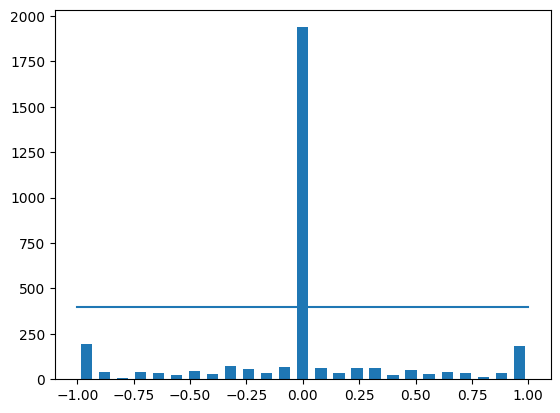

In [6]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center,hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))

In [7]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))

removed:  1538
remaining:  1667


In [8]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

In [9]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [10]:
image_paths

array(['/content/Self_driving/data/IMG/center_2024_01_25_22_48_25_700.jpg',
       '/content/Self_driving/data/IMG/left_2024_01_25_22_48_25_700.jpg',
       '/content/Self_driving/data/IMG/right_2024_01_25_22_48_25_700.jpg',
       ...,
       '/content/Self_driving/data/IMG/center_2024_02_02_09_53_08_394.jpg',
       '/content/Self_driving/data/IMG/left_2024_02_02_09_53_08_394.jpg',
       '/content/Self_driving/data/IMG/right_2024_02_02_09_53_08_394.jpg'],
      dtype='<U65')

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state = 6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 4000
Valid Samples: 1001


In [12]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle


In [13]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle

In [14]:
def img_preprocess(img):
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

In [15]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [20]:
def keras_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (5, 5), activation='elu'))
  # Add a skip connection here (consider from after the second convolutional layer)

  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.2))  # Add dropout
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))  # Add dropout
  model.add(Dense(10, activation='elu'))
  model.add(Dense(1))

  optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)  # Experiment with optimizer
  model.compile(loss='mse', optimizer=optimizer)
  return model

model = keras_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 batch_normalization_4 (Bat  (None, 31, 98, 24)        96        
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 batch_normalization_5 (Bat  (None, 14, 47, 36)        144       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 batch_normalization_6 (Bat  (None, 5, 22, 48)        

In [21]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=6,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

<ipython-input-21-d82df037bffe>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),


Epoch 1/6
300/300 [==============================] - 112s 363ms/step - loss: 0.6849 - val_loss: 0.4682
Epoch 2/6
300/300 [==============================] - 108s 361ms/step - loss: 0.2661 - val_loss: 0.3071
Epoch 3/6
300/300 [==============================] - 122s 408ms/step - loss: 0.2309 - val_loss: 0.3300
Epoch 4/6
300/300 [==============================] - 121s 404ms/step - loss: 0.2168 - val_loss: 0.2747
Epoch 5/6
300/300 [==============================] - 109s 366ms/step - loss: 0.1970 - val_loss: 0.2468
Epoch 6/6
300/300 [==============================] - 115s 384ms/step - loss: 0.1870 - val_loss: 0.1834


In [18]:
# def nvidia_model():
#   model = Sequential()
#   model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
#   model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
#   model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
#   model.add(Conv2D(64, (5, 5), activation='elu'))


#   model.add(Flatten())
#   model.add(Dense(100, activation = 'elu'))
#   model.add(Dense(50, activation = 'elu'))
#   model.add(Dense(10, activation = 'elu'))
#   model.add(Dense(1))

#   optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
#   model.compile(loss='mse', optimizer=optimizer)
#   return model

Text(0.5, 0, 'Epoch')

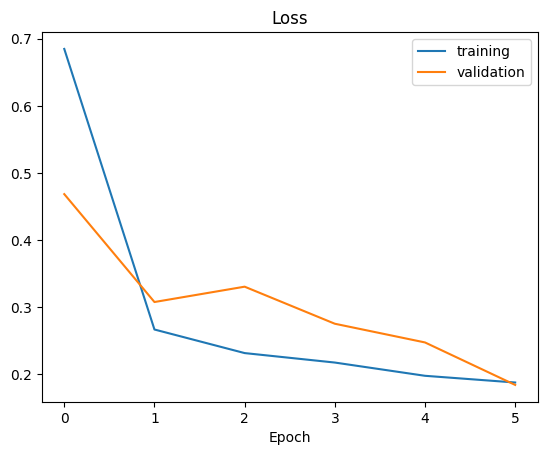

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')